In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.multioutput import MultiOutputClassifier

from sklearn.tree import DecisionTreeClassifier

import pickle

In [7]:
unpickleFile = open('../Datasets/final_data.pkl', 'rb')
df = pickle.load(unpickleFile, encoding='bytes')
df.head()

,SEX,AGE,MANEUVER,FIRST_CONTACT_POINT,LIGHTING_CONDITION,CRASH_TYPE,PRIM_CONTRIBUTORY_CAUSE,STREET_DIRECTION,CRASH_HOUR,CRASH_DAY_OF_WEEK,...,passengers_simple,defect_simple,vehicletype_simple,vehicleuse_simple,speedlimit_simple,weather_simple,roadcond_simple,roaddef_simple,trafficway_simple,alignment_simple
12,F,34.0,MERGING,TOTAL (ALL AREAS),DUSK,NO INJURY / DRIVE AWAY,IMPROPER OVERTAKING/PASSING,W,18.0,1.0,...,no passengers,defective/unknown,passenger car,personal vehicle,med,clear/unknown,dry,no road defect,not divided,straight
40,M,61.0,SLOW/STOP IN TRAFFIC,REAR-LEFT,DAYLIGHT,NO INJURY / DRIVE AWAY,FOLLOWING TOO CLOSELY,S,11.0,7.0,...,has passengers,not defective,other,personal vehicle,high,clear/unknown,dry,no road defect,divided,straight
60,F,24.0,STRAIGHT AHEAD,FRONT,"DARKNESS, LIGHTED ROAD",INJURY AND / OR TOW DUE TO CRASH,FAILING TO REDUCE SPEED TO AVOID CRASH,W,0.0,2.0,...,no passengers,defective/unknown,passenger car,personal vehicle,med,clear/unknown,dry,no road defect,not divided,straight
96,M,23.0,TURNING LEFT,SIDE-RIGHT,DAYLIGHT,NO INJURY / DRIVE AWAY,FAILING TO YIELD RIGHT-OF-WAY,W,7.0,6.0,...,no passengers,not defective,passenger car,personal vehicle,med,clear/unknown,dry,no road defect,other,straight
97,M,52.0,STRAIGHT AHEAD,OTHER,DAYLIGHT,NO INJURY / DRIVE AWAY,FAILING TO YIELD RIGHT-OF-WAY,W,7.0,6.0,...,has passengers,not defective,passenger car,personal vehicle,med,clear/unknown,dry,no road defect,other,straight


In [3]:
df.shape

(230514, 23)

In [4]:
df.dtypes

SEX                         object
AGE                        float64
MANEUVER                    object
FIRST_CONTACT_POINT         object
LIGHTING_CONDITION          object
CRASH_TYPE                  object
PRIM_CONTRIBUTORY_CAUSE     object
STREET_DIRECTION            object
CRASH_HOUR                 float64
CRASH_DAY_OF_WEEK          float64
CRASH_MONTH                float64
INJURY_LEVEL                object
se_simple                   object
passengers_simple           object
defect_simple               object
vehicletype_simple          object
vehicleuse_simple           object
speedlimit_simple           object
weather_simple              object
roadcond_simple             object
roaddef_simple              object
trafficway_simple           object
alignment_simple            object
dtype: object

In [8]:
# Create train/test split
X = df.drop('PRIM_CONTRIBUTORY_CAUSE', axis=1)
y = df[['PRIM_CONTRIBUTORY_CAUSE']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
# label encode target
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [7]:
le.classes_

array(['FAILING TO REDUCE SPEED TO AVOID CRASH',
       'FAILING TO YIELD RIGHT-OF-WAY', 'FOLLOWING TOO CLOSELY',
       'IMPROPER OVERTAKING/PASSING'], dtype=object)

In [8]:
# data is partially imbalanced(lowest class is 34% of largest class)
# will still need to apply SMOTE
y_train.value_counts()

PRIM_CONTRIBUTORY_CAUSE               
FAILING TO YIELD RIGHT-OF-WAY             65494
FOLLOWING TOO CLOSELY                     61163
FAILING TO REDUCE SPEED TO AVOID CRASH    23584
IMPROPER OVERTAKING/PASSING               22644
dtype: int64

In [9]:
# data is free of nan's
# This means we won't need to use imputer
df.isna().sum()

SEX                        0
AGE                        0
MANEUVER                   0
FIRST_CONTACT_POINT        0
LIGHTING_CONDITION         0
CRASH_TYPE                 0
PRIM_CONTRIBUTORY_CAUSE    0
STREET_DIRECTION           0
CRASH_HOUR                 0
CRASH_DAY_OF_WEEK          0
CRASH_MONTH                0
INJURY_LEVEL               0
se_simple                  0
passengers_simple          0
defect_simple              0
vehicletype_simple         0
vehicleuse_simple          0
speedlimit_simple          0
weather_simple             0
roadcond_simple            0
roaddef_simple             0
trafficway_simple          0
alignment_simple           0
dtype: int64

In [10]:
# Create pipes
subpipe_num = Pipeline(steps=[
#     Don't know why but imputer breaks the thing
#     ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler())
])


subpipe_cat = Pipeline(steps=[
#     gets stuck on imputer, unknown why
#     ('cat_impute',SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_num, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat, selector(dtype_include=object))], remainder='passthrough')

In [11]:
np.unique(y_train_enc, return_counts=True)

(array([0, 1, 2, 3]), array([23584, 65494, 61163, 22644], dtype=int64))

In [12]:
22644/65494

0.34574159464989157

In [13]:
# strategy = {0:100, 1:100, 2:200, 3:200, 4:200, 5:200}

# imb_dt_pipe = ImPipeline(steps=[
#     ('ct',CT),
#     ('sm',SMOTE(sampling_strategy='auto', random_state=42)),
#     ('dt', DecisionTreeClassifier(random_state=42))
# ])

In [14]:
# First gridsearch attempt
# Time to compute: 7:43-7:53, no results
# try restarting everything
# parameters = {
#     'dt__max_depth': [2,5],
#     'sm__k_neighbors': [3,5]
#     'sm__sampling_strategy': [0.8,0.6,0.4]
#     might come back to this later
# }


# gs_dt = GridSearchCV(imb_dt_pipe, parameters, n_jobs=-1, verbose=3)

In [15]:
# attempt after a comp restart
# jobs changed = 2
# k neighbors size reduced
# start 8pm-

In [12]:
# try fit etc manually, 1 step at a time
# start at 8:14

# I CANT BELIEVE A HANGING COMMA WAS CAUSING THE PROBLEM HOLY FUCK
# 2 FUCKIN DAYS I'VE BEEN TRYING TO FIGURE THIS OUT
# ok lets try the cross validate again
CT.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('subpipe_num',
                                 Pipeline(steps=[('ss', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001F696B958E0>),
                                ('subpipe_cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001F696B95730>)])

In [13]:
X_trans = CT.transform(X_train)

In [ ]:
# SMOTE breaks the thing - no idea why
# after some research: SMOTE is not good at larger datasets.
# takes a VERY long time

# sm = SMOTE(sampling_strategy='auto', random_state=42)

# X_clean_resmp, y_clean_resmp = sm.fit_resample(X_trans, y_train_enc)

# y_clean_resmp.value_counts()

In [ ]:
# gs_dt.fit(X_train, y_train_enc)

# DT w/ + w/o undersampling

In [18]:
# try undersampling
rus_dt_pipe = ImPipeline(steps=[
    ('ct',CT),
    ('rus',RandomUnderSampler(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
])

parameters = {
    'dt__max_depth': [2,3,4,5]
#     'rus__k_neighbors': [3,5]
#     'sm__sampling_strategy': [0.8,0.6,0.4]
}

gs_dt_us = GridSearchCV(rus_dt_pipe, parameters, verbose=3)

In [19]:
gs_dt_us.fit(X_train, y_train_enc)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] dt__max_depth=2 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... dt__max_depth=2, score=0.487, total=   1.4s
[CV] dt__max_depth=2 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ..................... dt__max_depth=2, score=0.486, total=   1.5s
[CV] dt__max_depth=2 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV] ..................... dt__max_depth=2, score=0.487, total=   1.5s
[CV] dt__max_depth=2 .................................................
[CV] ..................... dt__max_depth=2, score=0.488, total=   1.4s
[CV] dt__max_depth=2 .................................................
[CV] ..................... dt__max_depth=2, score=0.488, total=   1.4s
[CV] dt__max_depth=3 .................................................
[CV] ..................... dt__max_depth=3, score=0.549, total=   1.5s
[CV] dt__max_depth=3 .................................................
[CV] ..................... dt__max_depth=3, score=0.550, total=   1.5s
[CV] dt__max_depth=3 .................................................
[CV] ..................... dt__max_depth=3, score=0.550, total=   1.5s
[CV] dt__max_depth=3 .................................................
[CV] ..................... dt__max_depth=3, score=0.552, total=   1.6s
[CV] dt__max_depth=3 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   31.8s finished


GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001AE0C055100>),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                   

In [20]:
gs_dt_us.score(X_train, y_train_enc)
# IT WORKS LETS GOOO

0.5498799780200712

In [21]:
gs_dt_us.best_params_

{'dt__max_depth': 3}

In [22]:
dt_pipe = ImPipeline(steps=[
    ('ct',CT),
    ('dt', DecisionTreeClassifier(random_state=42)),
])
parameters = {
    'dt__max_depth': [2,3,4,5]
}
dt_gs = GridSearchCV(rus_dt_pipe, parameters, verbose=3)
dt_gs.fit(X_train, y_train_enc)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] dt__max_depth=2 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... dt__max_depth=2, score=0.487, total=   1.5s
[CV] dt__max_depth=2 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] ..................... dt__max_depth=2, score=0.486, total=   1.4s
[CV] dt__max_depth=2 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV] ..................... dt__max_depth=2, score=0.487, total=   1.6s
[CV] dt__max_depth=2 .................................................
[CV] ..................... dt__max_depth=2, score=0.488, total=   1.5s
[CV] dt__max_depth=2 .................................................
[CV] ..................... dt__max_depth=2, score=0.488, total=   1.5s
[CV] dt__max_depth=3 .................................................
[CV] ..................... dt__max_depth=3, score=0.549, total=   1.6s
[CV] dt__max_depth=3 .................................................
[CV] ..................... dt__max_depth=3, score=0.550, total=   1.6s
[CV] dt__max_depth=3 .................................................
[CV] ..................... dt__max_depth=3, score=0.550, total=   1.6s
[CV] dt__max_depth=3 .................................................
[CV] ..................... dt__max_depth=3, score=0.552, total=   1.6s
[CV] dt__max_depth=3 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   32.5s finished


GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001AE0C055100>),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                   

In [23]:
dt_gs.score(X_train, y_train_enc)
# IT WORKS LETS GOOO

0.5498799780200712

In [24]:
# looks like resampling does...nothing lol
# time to try other gs's :)

# RFC

In [14]:
rfc_model_pipe = Pipeline([
    ('ct',CT),
    ('rfc',RandomForestClassifier(random_state=42))
])

parameters = {
    'rfc__criterion': ['gini'],
    'rfc__min_samples_leaf': [1, 2, 3],
    'rfc__max_features': ['sqrt', 'log2', 'float']
}
rfc_gs = GridSearchCV(rfc_model_pipe, parameters, verbose=3)

In [38]:
rfc_gs.fit(X_train, y_train_enc)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] rfc__criterion=gini, rfc__max_features=sqrt, rfc__min_samples_leaf=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rfc__criterion=gini, rfc__max_features=sqrt, rfc__min_samples_leaf=1, score=0.626, total=  28.4s
[CV] rfc__criterion=gini, rfc__max_features=sqrt, rfc__min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.3s remaining:    0.0s


[CV]  rfc__criterion=gini, rfc__max_features=sqrt, rfc__min_samples_leaf=1, score=0.630, total=  28.1s
[CV] rfc__criterion=gini, rfc__max_features=sqrt, rfc__min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   56.5s remaining:    0.0s


[CV]  rfc__criterion=gini, rfc__max_features=sqrt, rfc__min_samples_leaf=1, score=0.627, total=  28.2s
[CV] rfc__criterion=gini, rfc__max_features=sqrt, rfc__min_samples_leaf=1 
[CV]  rfc__criterion=gini, rfc__max_features=sqrt, rfc__min_samples_leaf=1, score=0.631, total=  28.1s
[CV] rfc__criterion=gini, rfc__max_features=sqrt, rfc__min_samples_leaf=1 
[CV]  rfc__criterion=gini, rfc__max_features=sqrt, rfc__min_samples_leaf=1, score=0.625, total=  28.4s
[CV] rfc__criterion=gini, rfc__max_features=sqrt, rfc__min_samples_leaf=2 
[CV]  rfc__criterion=gini, rfc__max_features=sqrt, rfc__min_samples_leaf=2, score=0.637, total=  24.8s
[CV] rfc__criterion=gini, rfc__max_features=sqrt, rfc__min_samples_leaf=2 
[CV]  rfc__criterion=gini, rfc__max_features=sqrt, rfc__min_samples_leaf=2, score=0.640, total=  24.9s
[CV] rfc__criterion=gini, rfc__max_features=sqrt, rfc__min_samples_leaf=2 
[CV]  rfc__criterion=gini, rfc__max_features=sqrt, rfc__min_samples_leaf=2, score=0.639, total=  24.9s
[CV] rf

C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\si

[CV]  rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=1, score=nan, total=   1.0s
[CV] rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=1 


C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\si

[CV]  rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=1, score=nan, total=   1.0s
[CV] rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=1 


C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\si

[CV]  rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=1, score=nan, total=   1.1s
[CV] rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=1 


C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\si

[CV]  rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=1, score=nan, total=   1.0s
[CV] rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=1 


C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\si

[CV]  rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=1, score=nan, total=   1.1s
[CV] rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=2 


C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\si

[CV]  rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=2, score=nan, total=   1.0s
[CV] rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=2 


C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\si

[CV]  rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=2, score=nan, total=   1.0s
[CV] rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=2 


C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\si

[CV]  rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=2, score=nan, total=   1.0s
[CV] rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=2 


C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\si

[CV]  rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=2, score=nan, total=   1.0s
[CV] rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=2 


C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\si

[CV]  rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=2, score=nan, total=   1.1s
[CV] rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=3 


C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\si

[CV]  rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=3, score=nan, total=   1.0s
[CV] rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=3 


C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\si

[CV]  rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=3, score=nan, total=   1.1s
[CV] rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=3 


C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\si

[CV]  rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=3, score=nan, total=   1.0s
[CV] rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=3 


C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\si

[CV]  rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=3, score=nan, total=   1.1s
[CV] rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=3 


C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\mitch\anaconda3\envs\learn-env\lib\si

[CV]  rfc__criterion=gini, rfc__max_features=float, rfc__min_samples_leaf=3, score=nan, total=   1.0s


GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001AE0C055100>),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                   

In [20]:
# manual test again
X_trans = CT.fit_transform(X_train)

In [27]:
# manual pt2
rfc_model = RandomForestClassifier(random_state=42).fit(X_trans, y_train_enc)

In [29]:
# manual pt3
rfc_model.score(X_trans, y_train_enc)

0.9998438268212974

In [17]:
# manual pt4
X_test_trans= CT.transform(X_test)

In [19]:
# manual pt5
y_test_enc = le.transform(y_test)

C:\Users\mitch\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [36]:
# manual pt6
rfc_model.score(X_test_trans, y_test_enc)

0.6283294868902809

In [39]:
# gs of rfc results
rfc_gs.best_params_

{'rfc__criterion': 'gini',
 'rfc__max_features': 'sqrt',
 'rfc__min_samples_leaf': 2}

In [42]:
rfc_gs.cv_results_['mean_test_score']

array([0.62781618, 0.63851693, 0.6384186 , 0.62627758, 0.63742951,
       0.63778234,        nan,        nan,        nan])

In [15]:
# Manually remake best model bc of nan values
rfc_model_final = RandomForestClassifier(criterion='gini', max_features='sqrt', min_samples_leaf=2,
                                   random_state=42).fit(X_trans, y_train_enc)


In [20]:
rfc_model_final.score(X_test_trans, y_test_enc)

0.6370924360998803

In [23]:
# Save model
filename = 'rfc_model_final.sav'
pickle.dump(rfc_model_final, open(filename, 'wb'))

In [25]:
# Save test data(X)
filename = 'rfc_model_final_Xtest.sav'
pickle.dump(X_test_trans, open(filename, 'wb'))

# Save test data(y)
filename = 'rfc_model_final_ytest.sav'
pickle.dump(y_test_enc, open(filename, 'wb'))

# RFC final model analysis

In [30]:
importance = rfc_model_final.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.07904
Feature: 1, Score: 0.06944
Feature: 2, Score: 0.05088
Feature: 3, Score: 0.06060
Feature: 4, Score: 0.01246
Feature: 5, Score: 0.01247
Feature: 6, Score: 0.00004
Feature: 7, Score: 0.00094
Feature: 8, Score: 0.00594
Feature: 9, Score: 0.00522
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00002
Feature: 12, Score: 0.00386
Feature: 13, Score: 0.00958
Feature: 14, Score: 0.00071
Feature: 15, Score: 0.00163
Feature: 16, Score: 0.00014
Feature: 17, Score: 0.00143
Feature: 18, Score: 0.03821
Feature: 19, Score: 0.00180
Feature: 20, Score: 0.00065
Feature: 21, Score: 0.00021
Feature: 22, Score: 0.00044
Feature: 23, Score: 0.04480
Feature: 24, Score: 0.00141
Feature: 25, Score: 0.01870
Feature: 26, Score: 0.02782
Feature: 27, Score: 0.00001
Feature: 28, Score: 0.00386
Feature: 29, Score: 0.00064
Feature: 30, Score: 0.00148
Feature: 31, Score: 0.01474
Feature: 32, Score: 0.01704
Feature: 33, Score: 0.01641
Feature: 34, Score: 0.00169
Feature: 35, Score: 0.01593
Fe

In [ ]:
# reverse features


In [49]:
yhat = rfc_model_final.predict(X_test_trans)
# Recall
# use micro as there is some class imbalance
recall = recall_score(y_test_enc, yhat, average='micro')
recall

0.6370924360998803

In [50]:
accuracy = accuracy_score(y_test_enc, yhat)
accuracy

0.6370924360998803

In [51]:
precision = precision_score(y_test_enc, yhat, average='micro')
precision

0.6370924360998803

In [52]:
f1 = f1_score(y_test_enc, yhat, average='micro')
f1

0.6370924360998803

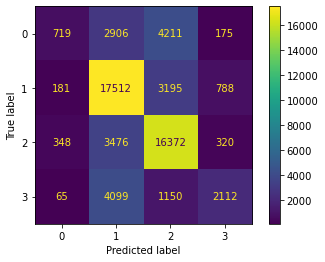

In [45]:
plot_confusion_matrix(rfc_model_final, X_test_trans, y_test_enc);

# Gradient Booster

In [16]:
gbc = GradientBoostingClassifier(random_state=42)

gbc_model_pipe = Pipeline([('ct', CT), ('gbc',gbc)])

parameters = {
    'gbc__loss': ['deviance'],
    'gbc__learning_rate': [0.01, 0.1],
    'gbc__max_depth': [2, 3]
}

gbc_gs = GridSearchCV(gbc_model_pipe, parameters, verbose=2)

In [17]:
gbc_gs.fit(X_train, y_train_enc)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] gbc__learning_rate=0.01, gbc__loss=deviance, gbc__max_depth=2 ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  gbc__learning_rate=0.01, gbc__loss=deviance, gbc__max_depth=2, total= 2.9min
[CV] gbc__learning_rate=0.01, gbc__loss=deviance, gbc__max_depth=2 ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s


[CV]  gbc__learning_rate=0.01, gbc__loss=deviance, gbc__max_depth=2, total= 2.9min
[CV] gbc__learning_rate=0.01, gbc__loss=deviance, gbc__max_depth=2 ...
[CV]  gbc__learning_rate=0.01, gbc__loss=deviance, gbc__max_depth=2, total= 2.9min
[CV] gbc__learning_rate=0.01, gbc__loss=deviance, gbc__max_depth=2 ...
[CV]  gbc__learning_rate=0.01, gbc__loss=deviance, gbc__max_depth=2, total= 2.9min
[CV] gbc__learning_rate=0.01, gbc__loss=deviance, gbc__max_depth=2 ...
[CV]  gbc__learning_rate=0.01, gbc__loss=deviance, gbc__max_depth=2, total= 2.8min
[CV] gbc__learning_rate=0.01, gbc__loss=deviance, gbc__max_depth=3 ...
[CV]  gbc__learning_rate=0.01, gbc__loss=deviance, gbc__max_depth=3, total= 4.1min
[CV] gbc__learning_rate=0.01, gbc__loss=deviance, gbc__max_depth=3 ...
[CV]  gbc__learning_rate=0.01, gbc__loss=deviance, gbc__max_depth=3, total= 4.2min
[CV] gbc__learning_rate=0.01, gbc__loss=deviance, gbc__max_depth=3 ...
[CV]  gbc__learning_rate=0.01, gbc__loss=deviance, gbc__max_depth=3, total= 

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 69.0min finished


GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000159693D2F40>),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                   

In [18]:
gbc_gs.cv_results_['mean_test_score'].mean()

0.6048471527315846